In [95]:
import LinearAlgebra: I, ⋅
import Base.MathConstants: φ
abstract type DescentMethod end

# Metody optymalizacji

## Gradient Descent

In [262]:
struct GradientDescent <: DescentMethod 
    α # learning rate
end

function step!(M::GradientDescent, f, ∇f, θ) 
    α, g = M.α, ∇f(θ)
    return θ - α*g
end

step! (generic function with 3 methods)

## BFGS

In [97]:
mutable struct BFGS <: DescentMethod
  Q
end
BFGS(n::Integer) = BFGS(Matrix(1.0I, n, n))

function strong_backtracking(f, ∇, x, d; α=1, β=1e-4, σ=0.1)
  y0, g0, y_prev, α_prev = f(x), ∇(x)⋅d, NaN, 0
  αlo, αhi = NaN, NaN
  # bracket phase
  while true
    y = f(x + α*d)
    if y > y0 + β*α*g0 || (!isnan(y_prev) && y ≥ y_prev)
      αlo, αhi = α_prev, α
      break
    end
    g = ∇(x + α*d)⋅d
    if abs(g) ≤ -σ*g0
      return α
    elseif g ≥ 0
      αlo, αhi = α, α_prev
      break
    end
    y_prev, α_prev, α = y, α, 2α
  end
  # zoom phase
  ylo = f(x + αlo*d)
  while true
    α = (αlo + αhi)/2
    y = f(x + α*d)
    if y > y0 + β*α*g0 || y ≥ ylo
      αhi = α
    else
      g = ∇(x + α*d)⋅d
      if abs(g) ≤ -σ*g0
        return α
      elseif g*(αhi - αlo) ≥ 0
        αhi = αlo
      end
      αlo = α
    end
  end
end

function step!(M::BFGS, f, ∇f, x)
  if f(x) ≈ 0.0
    return x
  end

  Q, g = M.Q, ∇f(x)
  α = strong_backtracking(f, ∇f, x, -Q*g)
  x′ = x + α*(-Q*g)
  g′ = ∇f(x′)
  δ = x′ - x
  γ = g′ - g
  Q[:] = Q - (δ*γ'*Q + Q*γ*δ')/(δ'*γ) + (1 + (γ'*Q*γ)/(δ'*γ))[1]*(δ*δ')/(δ'*γ)
  return x′
end

step! (generic function with 3 methods)

## L-BFGS

In [98]:
using LinearAlgebra

mutable struct LBFGS
  m
  δs
  γs
  qs
  LBFGS() = new()
end

function init!(M::LBFGS, m) 
  M.m = m
  M.δs = [] 
  M.γs = [] 
  M.qs = []
  return M
end

function step!(M::LBFGS, f, ∇f, θ) 
    δs, γs, qs = M.δs, M.γs, M.qs 
    m, g = length(δs), ∇f(θ)
    d = -g # kierunek
    if m > 0 
        q = g
        for i in m:-1:1
            qs[i] = copy(q)
            q -= (δs[i]⋅q) / (γs[i]⋅δs[i]) * γs[i]
        end
        z = (γs[m] .* δs[m] .* q) / (γs[m]⋅γs[m]) 
        for i in 1:+1:m
            z += δs[i]*(δs[i]⋅qs[i]-γs[i]⋅z)/(γs[i]⋅δs[i]) 
        end
        d = -z; # rekonstrukcja kierunku
    end
    φ =α-> f(θ+α*d); φ′=α->∇f(θ+α*d)⋅d 
    α = line_search(φ, φ′, d)
    θ′ = θ + α*d; g′ = ∇f(θ′) # nowy wektor
    δ =θ′-θ;γ =g′-g
    push!(δs, δ); push!(γs, γ); push!(qs, zero(θ)) 
    while length(δs) > M.m
        popfirst!(δs); popfirst!(γs); popfirst!(qs) 
    end
    return θ′ 
end

function zoom(φ, φ′, αlo, αhi, c1=1e-4, c2=0.1, jmax=1000)
    φ′0 = φ′(0.0) 
    for j=1:jmax
        αj = 0.5(αlo + αhi) # bisection 
        φαj = φ(αj)
        if φαj > φ(0.0) + c1*αj*φ′0 || φαj ≥ φ(αlo)
            αhi = αj 
        else
            φ′αj = φ′(αj)
            if abs(φ′αj) ≤ -c2*φ′0
                return αj
            end
            if φ′αj*(αhi - αlo) ≥ 0.0 
                αhi = αlo
            end
            αlo = αj 
        end
    end
    return 0.5(αlo + αhi) 
end

function line_search(φ, φ′, d, c1=1e-4, c2=0.1, ρ=0.1, αmax=100., jmax=1000)
    αi, αj = 0.0, 1.0
    φαi, φ0, φ′0 = φ(αi), φ(0.0), φ′(0.0) 
    for j=1:jmax
        φαj = φ(αj)
        if φαj > φ0 + c1*αj*φ′0 || (φαj ≥ φαi && j > 1)
            return zoom(φ, φ′, αi, αj)
        end
        φ′αj = φ′(αj)
        if abs(φ′αj) ≤ -c2*φ′0
            return αj 
        end
        if φ′αj ≥ 0.0
            return zoom(φ, φ′, αj, αi)
        end
        αi, αj = αj, ρ*αj + (1.0 - ρ)*αmax
        φαi = φαj 
    end
    return αj 
end

line_search (generic function with 6 methods)

# Testowanie

In [302]:
function optimalize(f, ∇f, x₀, opt, e, i)
    pts = [x₀] # kolejne wektory x
    xs = [pts[end][1]]
    ys = [pts[end][2]]
    err = Float64[] # kolejne wartości f. straty
    p = 0
    while true
        new_err = f(pts[end])
        new_x = step!(opt, f, ∇f, pts[end])
        
        if isinf(new_err) # błąd równy nieskończoność
            break
        end
        
        if new_err < e || p >= i # wynik odpowiednio dokładny lub wykonano wystarczająco iteracji
            break
        end
        
        if isinf(new_x[1]) || isinf(new_x[2]) # któryś x równy nieskończoność
            break
        end
        
        push!(err, new_err) # odłóż wynik funkcji dla najnowszego wektora x (miara błędu)
        push!(pts, new_x)
        push!(xs, new_x[1])
        push!(ys, new_x[2])
        
        p += 1
    end
    
    pts, err, p, xs, ys
end

optimalize (generic function with 1 method)

In [269]:
f_beale(x) = (1.5 - x[1] + x[1]*x[2])^2 + (2.25 - x[1] + x[1]*x[2]^2)^2 + (2.625 - x[1] + x[1]*x[2]^3)^2
∇f_beale(x) = [
    2*x[1]*(x[2]^6 + x[2]^4 - 2*x[2]^3 - x[2]^2 - 2*x[2] + 3) + 5.25*x[2]^3 + 4.5*x[2]^2 + 3*x[2] - 12.75, 
    6*x[1]*(x[1]*(x[2]^5 + 0.666667*x[2]^3 - x[2]^2 - 0.333333*x[2] - 0.333333) + 2.625*x[2]^2 + 1.5x[2] + 0.5)
]

f_rosenbrock(x)  = 100*(x[2] - x[1]^2)^2 + (1-x[1])^2
∇f_rosenbrock(x) = [
    400x[1]^3 - 400x[1]*x[2] + 2x[1] - 2,
    200x[2] - 200x[1]^2
]

f_simple(x) = x[1]^2 + x[2]^2
∇f_simple(x) = [
    2*x[1],
    2*x[2]
]

∇f_simple (generic function with 1 method)

In [215]:
import Plots: reshape

function plot_opt(l, r, step, f, xs, ys)
    v = -10:.5:+10
    n = length(v)
    xv = repeat(v, inner=n) 
    yv = repeat(v, outer=n)
    zv = Float64[]
    for i in 1:length(xv)
        push!(zv, f([xv[i], yv[i]]))
    end
    zv = reshape(zv, n, n)
    contour(v, v, zv, fill=true)
    plot!(xs, ys)
    scatter!(xs, ys)
end

plot_opt (generic function with 1 method)

## Prosta funkcja

Ilość iteracji: 23
Wektor x wynikowy: [-0.05902958103587057, 0.05902958103587057]
Wektor oczekiwany: [0.0, 0.0]
Błąd: 0.010889035741470033


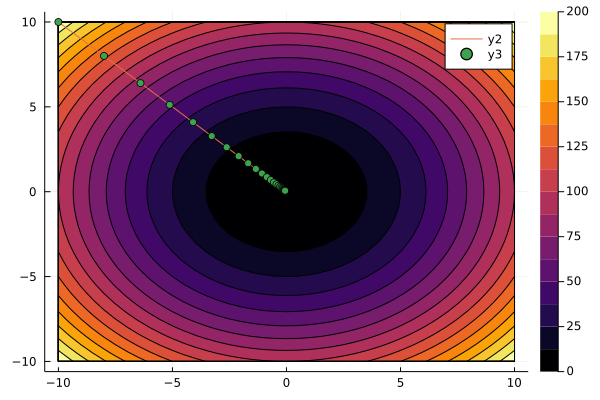

In [303]:
x = [-10.0, 10.0]
grad = GradientDescent(0.1)

pts, err, i, xs, ys = optimalize(f_simple, ∇f_simple, x, grad, 0.01, 100)
println("Ilość iteracji: ", i)
println("Wektor x wynikowy: ", pts[end])
println("Wektor oczekiwany: [0.0, 0.0]")
println("Błąd: ", err[end])

plot_opt(-10, 10, .5, f_simple, xs, ys)

Ilość iteracji: 1
Wektor x wynikowy: [0.0, 0.0]
Wektor oczekiwany: [0.0, 0.0]
Błąd: 200.0


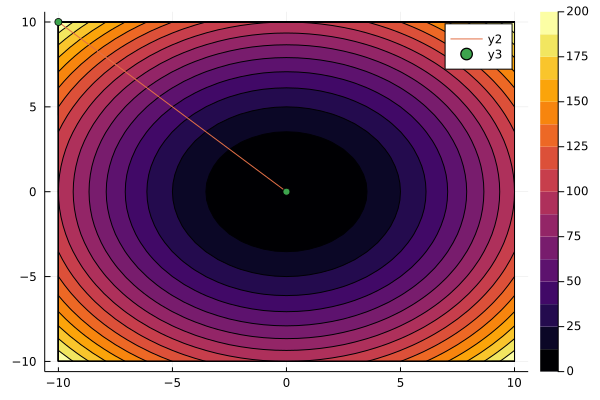

In [304]:
x = [-10.0, 10.0]
bfgs = BFGS(2)

pts, err, i, xs, ys = optimalize(f_simple, ∇f_simple, x, bfgs, 0.01, 100)
println("Ilość iteracji: ", i)
println("Wektor x wynikowy: ", pts[end])
println("Wektor oczekiwany: [0.0, 0.0]")
println("Błąd: ", err[end])

plot_opt(-10, 10, .5, f_simple, xs, ys)

Ilość iteracji: 1
Wektor x wynikowy: [0.0, 0.0]
Wektor oczekiwany: [0.0, 0.0]
Błąd: 200.0


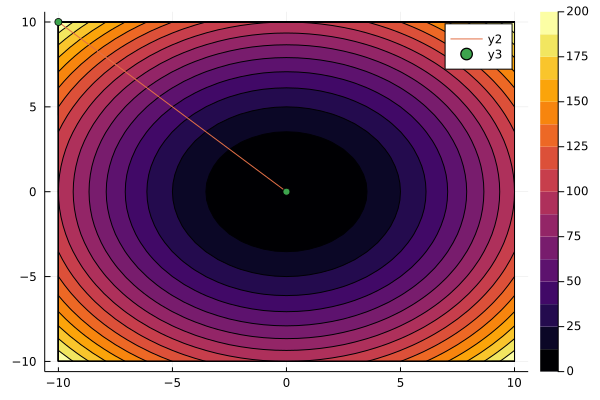

In [305]:
x = [-10.0, 10.0]
lbfgs = LBFGS(); init!(lbfgs, 7)

pts, err, i, xs, ys = optimalize(f_simple, ∇f_simple, x, lbfgs, 0.01, 100)
println("Ilość iteracji: ", i)
println("Wektor x wynikowy: ", pts[end])
println("Wektor oczekiwany: [0.0, 0.0]")
println("Błąd: ", err[end])

plot_opt(-10, 10, .5, f_simple, xs, ys)

## Funkcja Rosenbrocka

Ilość iteracji: 100
Wektor x wynikowy: [0.5896221029873153, 0.23076132003600663]
Wektor oczekiwany: [1.0, 1.0]
Błąd: 1.593598758407219


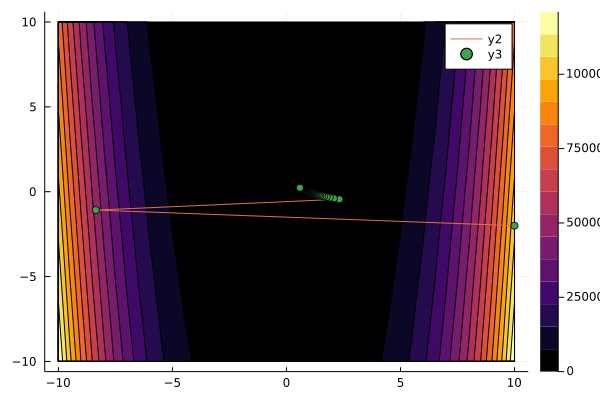

In [322]:
x = [10.0, -2.0]
grad = GradientDescent(0.000045)

pts, err, i, xs, ys = optimalize(f_rosenbrock, ∇f_rosenbrock, x, grad, 0.01, 100)
println("Ilość iteracji: ", i)
println("Wektor x wynikowy: ", pts[end])
println("Wektor oczekiwany: [1.0, 1.0]")
println("Błąd: ", err[end])

plot_opt(-10, 10, .5, f_rosenbrock, xs, ys)

Ilość iteracji: 24
Wektor x wynikowy: [0.9125393746819922, 0.8322982532604228]
Wektor oczekiwany: [1.0, 1.0]
Błąd: 0.007667838692333184


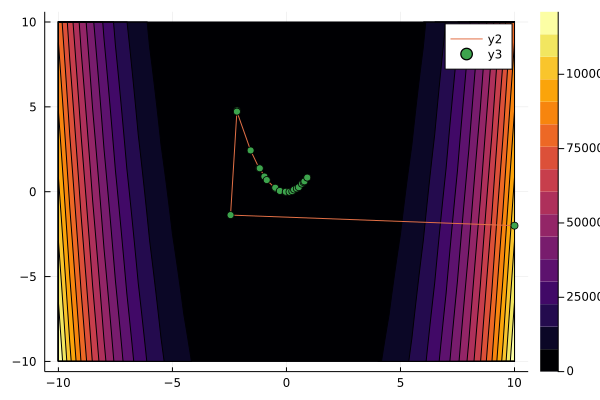

In [297]:
x = [10.0, -2.0]
bfgs = BFGS(2)

pts, err, i, xs, ys = optimalize(f_rosenbrock, ∇f_rosenbrock, x, bfgs, 0.01, 100)
println("Ilość iteracji: ", i)
println("Wektor x wynikowy: ", pts[end])
println("Wektor oczekiwany: [1.0, 1.0]")
println("Błąd: ", err[end])

plot_opt(-10, 10, .5, f_rosenbrock, xs, ys)

Ilość iteracji: 12
Wektor x wynikowy: [0.9749814637994931, 0.9498599257342828]
Wektor oczekiwany: [1.0, 1.0]
Błąd: 0.000679060904990904


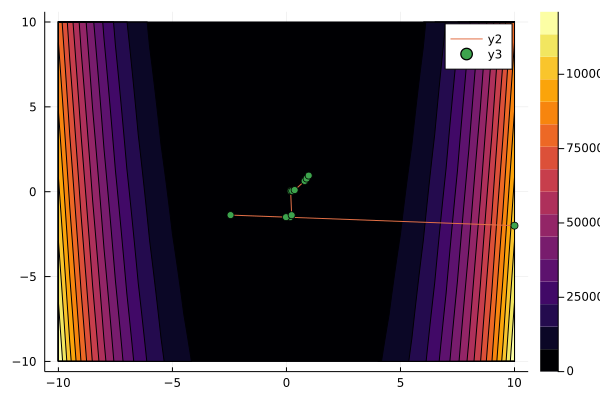

In [298]:
x = [10.0, -2.0]
lbfgs = LBFGS(); init!(lbfgs, 7)

pts, err, i, xs, ys = optimalize(f_rosenbrock, ∇f_rosenbrock, x, lbfgs, 0.01, 100)
println("Ilość iteracji: ", i)
println("Wektor x wynikowy: ", pts[end])
println("Wektor oczekiwany: [1.0, 1.0]")
println("Błąd: ", err[end])

plot_opt(-10, 10, .5, f_rosenbrock, xs, ys)

## Funkcja Beale'ego

Ilość iteracji: 101
Wektor x wynikowy: [9.849915976458638, -0.5156722800031917]
Wektor oczekiwany: [3.0, 0.5]
Błąd: 278.69237712754546


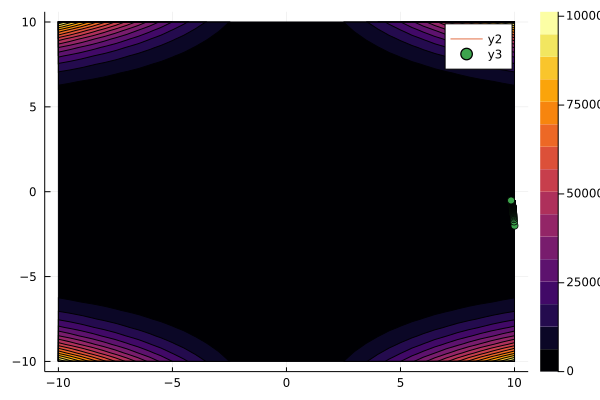

In [299]:
x = [10.0, -2.0]
grad = GradientDescent(0.00001)

pts, err, i, xs, ys = optimalize(f_beale, ∇f_beale, x, grad, 0.01, 100)
println("Ilość iteracji: ", i)
println("Wektor x wynikowy: ", pts[end])
println("Wektor oczekiwany: [3.0, 0.5]")
println("Błąd: ", err[end])

plot_opt(-10, 10, .5, f_beale, xs, ys)

Ilość iteracji: 15
Wektor x wynikowy: [3.0105081437129044, 0.5132368115603638]
Wektor oczekiwany: [3.0, 0.5]
Błąd: 0.0027146805241721086


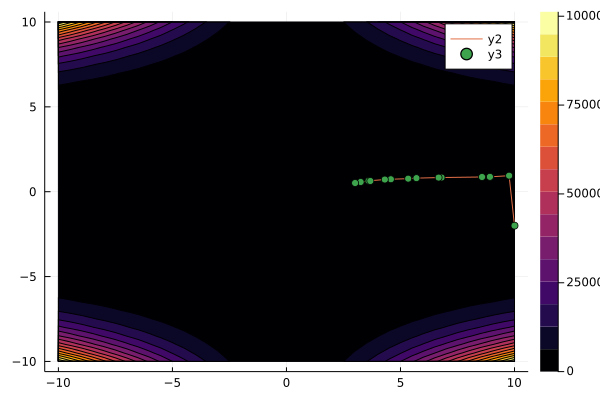

In [300]:
x = [10.0, -2.0]
bfgs = BFGS(2)

pts, err, i, xs, ys = optimalize(f_beale, ∇f_beale, x, bfgs, 0.01, 100)
println("Ilość iteracji: ", i)
println("Wektor x wynikowy: ", pts[end])
println("Wektor oczekiwany: [3.0, 0.5]")
println("Błąd: ", err[end])

plot_opt(-10, 10, .5, f_beale, xs, ys)

Ilość iteracji: 15
Wektor x wynikowy: [3.142790648632128, 0.5396101288639475]
Wektor oczekiwany: [3.0, 0.5]
Błąd: 0.003892327316145061


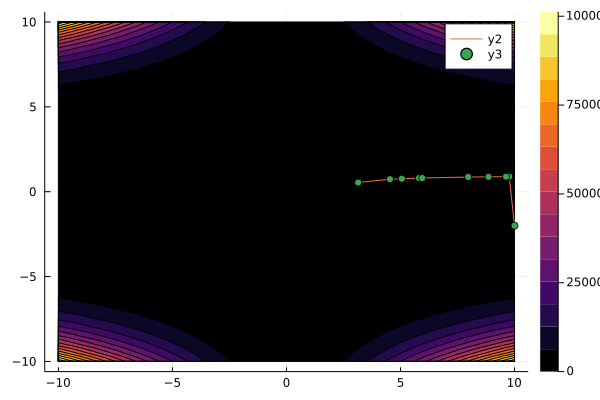

In [301]:
x = [10.0, -2.0]
lbfgs = LBFGS(); init!(lbfgs, 7)

pts, err, i, xs, ys = optimalize(f_beale, ∇f_beale, x, lbfgs, 0.01, 100)
println("Ilość iteracji: ", i)
println("Wektor x wynikowy: ", pts[end])
println("Wektor oczekiwany: [3.0, 0.5]")
println("Błąd: ", err[end])

plot_opt(-10, 10, .5, f_beale, xs, ys)